<a href="https://colab.research.google.com/github/vubanc/AWS_DeployedCLVPredictor/blob/main/AWS_DeployedCLVPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Wrangling

This notebook covers the data exploration, cleaning, preprocessing and feature engineering steps of the project. The prepared dataset is uploaded to an S3 bucket for SQL querying and model training.

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

Matplotlib is building the font cache; this may take a moment.


In [3]:
%pwd

'/home/ec2-user/SageMaker/AWS_DeployedCLVPredictor'

In [4]:
df = pd.read_excel("Raw Dataset/UK Online Retail.xlsx")

In [5]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
df.head(2)

Number of rows: 541909
Number of columns: 8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Exploratory Data Analysis

#### Checking data types

In [6]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

#### Checking null values

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### Descriptive statistics

In [8]:
df[["Quantity", "UnitPrice"]].describe(percentiles=[0.003, 0.25, 0.5, 0.75, 0.997])

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
0.3%,-22.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
99.7%,240.000000,39.950000
max,80995.000000,38970.000000


#### Distribution

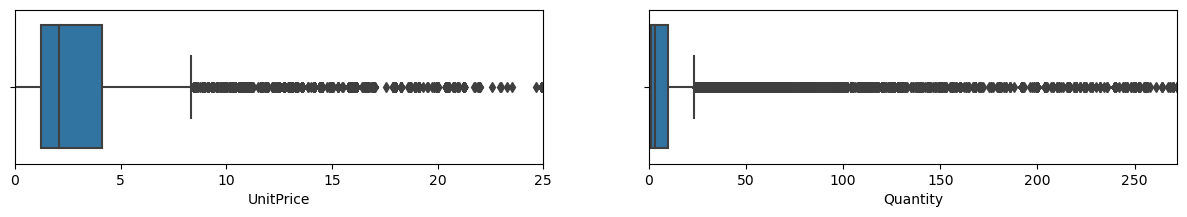

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 2))

sns.boxplot(x=df["UnitPrice"].astype(float), ax=axs[0])
sns.boxplot(x=df["Quantity"].astype(float), ax=axs[1])

axs[0].set_xlim(left=0, right=25) # right limit set to 99.7 percentile value
axs[1].set_xlim(left=0, right=272) # right limit set to 99.7 percentile value

plt.show()

#### Number of purchases by month

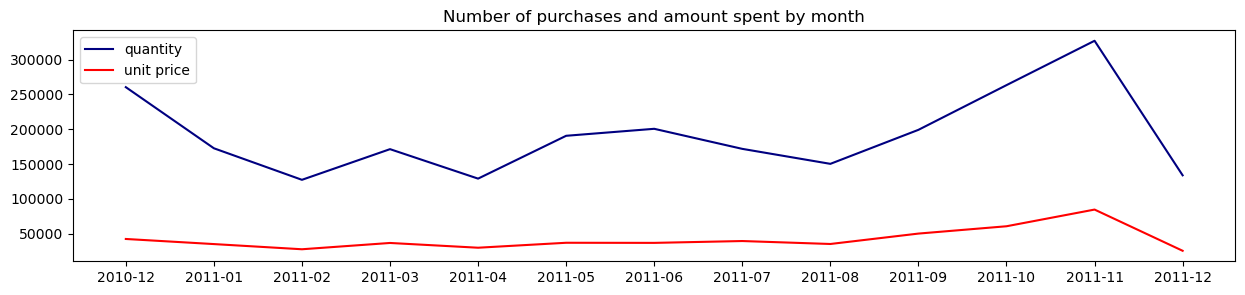

In [10]:
df_price = df.groupby(df.InvoiceDate.dt.strftime("%Y-%m"), as_index=True)["UnitPrice"].sum()
df_quantity = df.groupby(df.InvoiceDate.dt.strftime("%Y-%m"), as_index=True)["InvoiceNo"].count()


plt.figure(figsize=(15,3))
plt.title("Number of purchases and amount spent by month")
plt.plot(df_price, color='navy')
plt.plot(df_quantity, color='red')
plt.legend(['quantity', 'unit price'])

plt.show()

#### Top 5 frequent purchasing countries

In [11]:
df_quantity = df.groupby("Country", as_index=False)["InvoiceNo"].count()
df_quantity.sort_values(by="InvoiceNo", ascending=False, inplace=True)
df_quantity.head()

,Country,InvoiceNo
36,United Kingdom,495478
14,Germany,9495
13,France,8557
10,EIRE,8196
31,Spain,2533


## Data Preprocessing and Feature Engineering

#### Dropping observations with unknown customer IDs

In [12]:
obs_before = df.shape[0]
df.dropna(subset=["CustomerID"], inplace=True)
print(f"Observations dropped: {obs_before-df.shape[0]}")
print(f"Observations remaining: {df.shape[0]}")

Observations dropped: 135080
Observations remaining: 406829


#### Removing observations with negative quantity

In [13]:
obs_before = df.shape[0]
df = df[df.Quantity > 0]
print(f"Observations dropped: {obs_before-df.shape[0]}")
print(f"Observations remaining: {df.shape[0]}")

Observations dropped: 8905
Observations remaining: 397924


#### Separating training and prediction periods

In [31]:
df = df[df.InvoiceDate.dt.year == 2011]
df1 = df[df.InvoiceDate.dt.month <= 6]
df2 = df[df.InvoiceDate.dt.month > 6]
df2 = df2[df2.CustomerID.isin(df1.CustomerID)]

print(f"Total Customers: {len(df2.CustomerID.unique())}")

Total Customers: 1871


#### Creating input features

In [32]:
# Creating the recency feature
df1_CustomerRecency = df1.groupby("CustomerID", as_index=False)["InvoiceDate"].max()
df1_CustomerRecency["Recency"] = (df1.InvoiceDate.max() - df1_CustomerRecency.InvoiceDate).dt.days
df1_CustomerRecency.drop("InvoiceDate", axis=1, inplace=True)
df1 = pd.merge(df1, df1_CustomerRecency, how="inner", on="CustomerID")

In [33]:
# Creating the frequency feature
df1_CustomerFreq = df1.groupby("CustomerID", as_index=False)["InvoiceNo"].count()
df1_CustomerFreq.rename(columns={"InvoiceNo": "Frequency"}, inplace=True)
df1 = pd.merge(df1, df1_CustomerFreq, how="inner", on="CustomerID")

In [34]:
# Creating the monetary value feature
df1["MonetaryValue"] = df1.Quantity * df1.UnitPrice
df1_MonetaryValue = df1.groupby("CustomerID", as_index=False)["MonetaryValue"].sum()
df1.drop(labels=["MonetaryValue"], axis=1, inplace=True)
df1 = pd.merge(df1, df1_MonetaryValue, how="inner", on="CustomerID")

df2["MonetaryValue"] = df2.Quantity * df2.UnitPrice
df2_MonetaryValue = df2.groupby("CustomerID", as_index=False)["MonetaryValue"].sum()
df2.drop(labels=["MonetaryValue"], axis=1, inplace=True)
df2 = pd.merge(df2, df2_MonetaryValue, how="inner", on="CustomerID")

In [35]:
#Creating average daily spending feature
df1["InvoiceDate"] = pd.to_datetime(df1["InvoiceDate"].dt.strftime("%Y-%m-%d"))
df1_CustomerDays = df1.groupby("CustomerID", as_index=False)["InvoiceDate"].nunique()
df1_CustomerDays.rename(columns={"InvoiceDate":"TotalDays"}, inplace=True)
df1 = pd.merge(df1, df1_CustomerDays, how="inner", on="CustomerID")
df1["DailySpending"] = df1.MonetaryValue/df1.TotalDays

In [36]:
#Creating average daily transaction count feature
df1_CustomerDays = df1.groupby("CustomerID", as_index=False)["InvoiceDate"].nunique()
df1_DailyTransCount = df1.groupby("CustomerID", as_index=False)["InvoiceNo"].count()
df1_DailyTransCount = pd.merge(df1_DailyTransCount, df1_CustomerDays, how="inner", on="CustomerID")
df1_DailyTransCount["DailyTransCount"] = np.round(df1_DailyTransCount.InvoiceNo/df1_DailyTransCount.InvoiceDate)
df1_DailyTransCount.drop(labels=["InvoiceNo", "InvoiceDate"], axis=1, inplace=True)
df1 = pd.merge(df1, df1_DailyTransCount, how="inner", on="CustomerID")

#### Creating the input dataset

In [37]:
df1 = df1[["CustomerID", "Country", "Recency", "Frequency", "DailySpending", "DailyTransCount", "MonetaryValue"]]
df1.drop_duplicates(subset=["CustomerID"], inplace=True)
df1.reset_index(drop=True, inplace=True)
df1.head(2)

,CustomerID,Country,Recency,Frequency,DailySpending,DailyTransCount,MonetaryValue
0,13313.0,United Kingdom,53,31,304.87,16.0,609.74
1,18097.0,United Kingdom,43,49,637.02,24.0,1274.04


In [38]:
df2 = df2[["CustomerID", "MonetaryValue"]]
df2.drop_duplicates(subset=["CustomerID"], inplace=True)
df2.reset_index(drop=True, inplace=True)
df2.head(2)

,CustomerID,MonetaryValue
0,16317.0,770.89
1,13492.0,954.54


In [39]:
df_input = pd.merge(df1, df2, how="inner", on="CustomerID")

df_input = df_input[["CustomerID", "Recency", "Frequency", "DailySpending", "DailyTransCount", "MonetaryValue_x", "MonetaryValue_y"]]
df_input.head(2)

,CustomerID,Recency,Frequency,DailySpending,DailyTransCount,MonetaryValue_x,MonetaryValue_y
0,13313.0,53,31,304.87,16.0,609.74,945.58
1,18097.0,43,49,637.02,24.0,1274.04,1241.24


#### Treating Outliers in the input dataset with KNN imputer

Number of outliers in Recency: 92
Number of outliers in Frequency: 165
Number of outliers in Average Daily Spending: 154
Number of outliers in Daily Transaction Count: 153
Number of outliers in monetary value (training period): 144
Number of outliers in monetary value (prediction period): 248


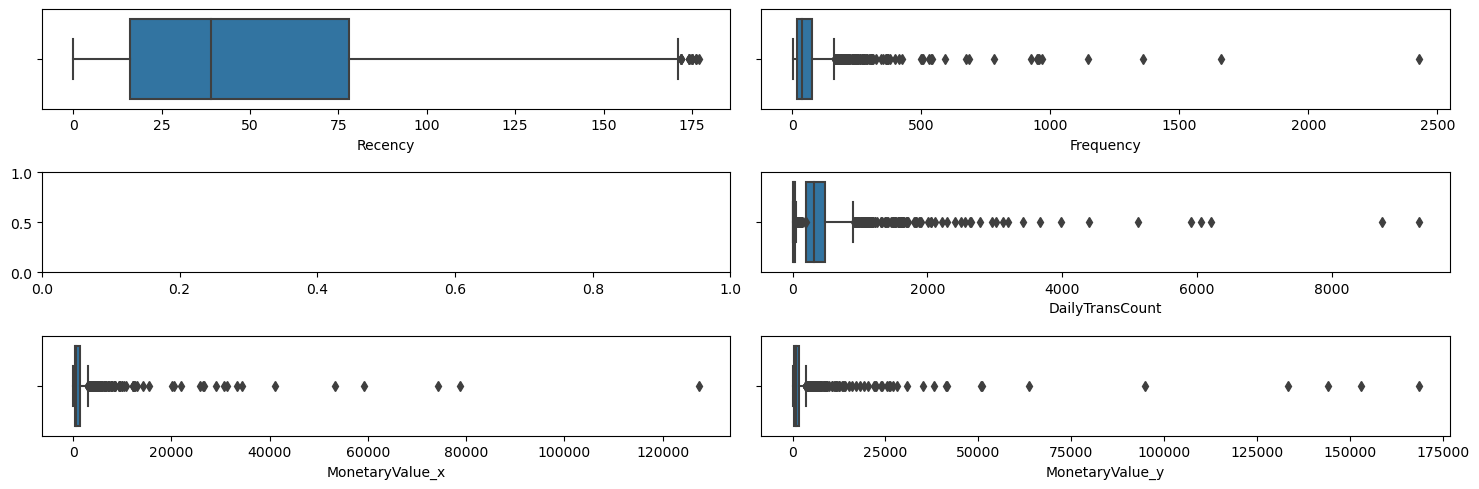

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(15, 5))

sns.boxplot(x=df_input["Recency"], ax=axs[0,0])
sns.boxplot(x=df_input["Frequency"], ax=axs[0,1])
sns.boxplot(x=df_input["DailySpending"], ax=axs[1,1])
sns.boxplot(x=df_input["DailyTransCount"], ax=axs[1,1])
sns.boxplot(x=df_input["MonetaryValue_x"], ax=axs[2,0])
sns.boxplot(x=df_input["MonetaryValue_y"], ax=axs[2,1])

q1, q3 = df_input.Recency.quantile(q=0.25), df_input.Recency.quantile(q=0.75)
iqr = q3-q1
recency_outliers = df_input[(df_input.Recency < df_input.Recency.mean()-1.5*iqr)|(df_input.Recency > df_input.Recency.mean()+1.5*iqr)]

q1, q3 = df_input.Frequency.quantile(q=0.25), df_input.Frequency.quantile(q=0.75)
iqr = q3-q1
frequency_outliers = df_input[(df_input.Frequency < df_input.Frequency.mean()-1.5*iqr)|(df_input.Frequency > df_input.Frequency.mean()+1.5*iqr)]

q1, q3 = df_input.DailySpending.quantile(q=0.25), df_input.DailySpending.quantile(q=0.75)
iqr = q3-q1
DailySpending_outliers = df_input[(df_input.DailySpending < df_input.DailySpending.mean()-1.5*iqr)|(df_input.DailySpending > df_input.DailySpending.mean()+1.5*iqr)]

q1, q3 = df_input.DailyTransCount.quantile(q=0.25), df_input.DailyTransCount.quantile(q=0.75)
iqr = q3-q1
DailyTransCount_outliers = df_input[(df_input.DailyTransCount < df_input.DailyTransCount.mean()-1.5*iqr)|(df_input.DailyTransCount > df_input.DailyTransCount.mean()+1.5*iqr)]

q1, q3 = df_input.MonetaryValue_x.quantile(q=0.25), df_input.MonetaryValue_x.quantile(q=0.75)
iqr = q3-q1
monetaryvalx_outliers = df_input[(df_input.MonetaryValue_x < df_input.MonetaryValue_x.mean()-1.5*iqr)|(df_input.MonetaryValue_x > df_input.MonetaryValue_x.mean()+1.5*iqr)]

q1, q3 = df_input.MonetaryValue_y.quantile(q=0.25), df_input.MonetaryValue_y.quantile(q=0.75)
iqr = q3-q1
monetaryvaly_outliers = df_input[(df_input.MonetaryValue_y < df_input.MonetaryValue_y.mean()-1.5*iqr)|(df_input.MonetaryValue_y > df_input.MonetaryValue_y.mean()+1.5*iqr)]

print(f"Number of outliers in Recency: {recency_outliers.shape[0]}")
print(f"Number of outliers in Frequency: {frequency_outliers.shape[0]}")
print(f"Number of outliers in Average Daily Spending: {DailySpending_outliers.shape[0]}")
print(f"Number of outliers in Daily Transaction Count: {DailyTransCount_outliers.shape[0]}")
print(f"Number of outliers in monetary value (training period): {monetaryvalx_outliers.shape[0]}")
print(f"Number of outliers in monetary value (prediction period): {monetaryvaly_outliers.shape[0]}")

plt.tight_layout()

In [41]:
from sklearn.impute import KNNImputer

df_imputed = df_input

df_imputed.loc[df_imputed.Recency.isin(recency_outliers.Recency), "Recency"] = np.nan
df_imputed.loc[df_imputed.Frequency.isin(frequency_outliers.Frequency), "Frequency"] = np.nan
df_imputed.loc[df_imputed.DailySpending.isin(DailySpending_outliers.DailySpending), "DailySpending"] = np.nan
df_imputed.loc[df_imputed.DailyTransCount.isin(DailyTransCount_outliers.DailyTransCount), "DailyTransCount"] = np.nan
df_imputed.loc[df_imputed.MonetaryValue_x.isin(monetaryvalx_outliers.MonetaryValue_x), "MonetaryValue_x"] = np.nan
df_imputed.loc[df_imputed.MonetaryValue_y.isin(monetaryvaly_outliers.MonetaryValue_y), "MonetaryValue_y"] = np.nan

knn_imputer = KNNImputer(n_neighbors = 5)
df_input = pd.DataFrame(knn_imputer.fit_transform(df_imputed))
df_input.columns = ["CustomerID", "Recency", "Frequency", "DailySpending", "DailyTransCount", "MonetaryValue_x", "MonetaryValue_y"]

#### Adding the country column

In [42]:
df_input = pd.merge(df_input, df, how="left", on="CustomerID")
df_input = df_input[["CustomerID", "Country", "Recency", "Frequency", "DailySpending", "DailyTransCount", "MonetaryValue_x", "MonetaryValue_y"]]
df_input = df_input.drop_duplicates(subset=["CustomerID"])
df_input["CustomerID"] = df_input.CustomerID.astype(int)
df_input.reset_index(inplace=True, drop=True)
df_input.head(2)

,CustomerID,Country,Recency,Frequency,DailySpending,DailyTransCount,MonetaryValue_x,MonetaryValue_y
0,13313,United Kingdom,53.0,31.0,304.87,16.0,609.74,945.58
1,18097,United Kingdom,43.0,49.0,637.02,24.0,1274.04,1241.24


In [43]:
df_input.shape

(1871, 8)

In [44]:
df_input.to_csv("df_input.csv", index=False)

## Initiating Sagemaker Session and Uploading Datasets

In [45]:
import sagemaker
import boto3
import botocore

config = botocore.config.Config()
sm = boto3.client(service_name="sagemaker", config=config)
sess = sagemaker.Session(sagemaker_client=sm)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

In [46]:
s3_uri = sess.upload_data(bucket=bucket, key_prefix="data/input", path = "df_input.csv")
s3_uri

's3://sagemaker-us-east-2-397738742408/data/input/df_input.csv'

In [47]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 buckets</a></b>'.format(region)))